In [2]:
import glob
# from slab import *
#import PyInventor
#from PyInventor import *
%load_ext autoreload
%autoreload 2
#import pyEPR as epr
#from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

import pandas as pd
import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()    
Q = ureg.Quantity
import os
import matplotlib.pyplot as plt

def flt2strfmt(val, fmt='%.3f', units='mm'):
    return (fmt % val) + units

import matplotlib
import datetime
dstr = datetime.datetime.today().strftime('%y%m%d')

# Add junction and chip

In [3]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
# Toggle between eigenmode and driven modal
solution_type = 'driven_modal' 
# solution_type = 'eigenmode'

# Define the cavity parameters [mm]
z_cav_1 = 100
y_cav_1 = 25
x_cav_1 = 10
z_cav_2 = 105
y_cav_2 = 25
x_cav_2 = 10
z_offset = 0
cav_thickness = 1

# Define the coupler parameters [mmm]
z_coupler = 30.
y_coupler = 0.5
x_coupler = 2.5

# Substrate dimensions
x_sub = x_coupler
y_sub = 0.450 # 450 um
z_sub = 5.

# Offsets of the junction pads
ycoupler_offset = 0.
zcoupler_offset = 0.

# Light and heavy modes (500, 100 um)
# l_junc = 500e-3
# l_junc = 100e-3
l_junc = 0.05
coupler_pads = (x_coupler - l_junc) / 2
y_pads = 0.1
w_junc = l_junc / 2 * 1e-3

# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
ref_name = 'planar_pads_l_coupled_three_cavities_bbq_y11_nondegen'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_em_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_em_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

# Geometry parameters
zcav1 = EM_design.set_variable('z_cav_1', flt2strfmt(z_cav_1))
ycav1 = EM_design.set_variable('y_cav_1', flt2strfmt(y_cav_1))
xcav1 = EM_design.set_variable('x_cav_1', flt2strfmt(x_cav_1))
zcav2 = EM_design.set_variable('z_cav_2', flt2strfmt(z_cav_2))
ycav2 = EM_design.set_variable('y_cav_2', flt2strfmt(y_cav_2))
xcav2 = EM_design.set_variable('x_cav_2', flt2strfmt(x_cav_2))
zcpl  = EM_design.set_variable('z_coupler', flt2strfmt(z_coupler))
ycpl  = EM_design.set_variable('y_coupler', flt2strfmt(y_coupler))
xcpl  = EM_design.set_variable('x_coupler', flt2strfmt(x_coupler))
ycpl_offset = EM_design.set_variable('ycoupler_offset',
                                    flt2strfmt(ycoupler_offset))
zcpl_offset = EM_design.set_variable('zcoupler_offset',
                                    flt2strfmt(zcoupler_offset))
z_offset  = EM_design.set_variable('z_offset', flt2strfmt(z_offset))
x_cpl_offset = EM_design.set_variable('x_cpl_offset', flt2strfmt(2e3*x_cav_1))
tcav = EM_design.set_variable('cav_thickness', flt2strfmt(cav_thickness))
cpl_pads = EM_design.set_variable('coupler_pads', flt2strfmt(coupler_pads))
ypads = EM_design.set_variable('y_pads', flt2strfmt(y_pads))
ljunc = EM_design.set_variable('l_junc', flt2strfmt(l_junc))

xsub = EM_design.set_variable('x_sub', flt2strfmt(x_sub))
ysub = EM_design.set_variable('y_sub', flt2strfmt(y_sub))
zsub = EM_design.set_variable('z_sub', flt2strfmt(z_sub))

print(f'z_offset: {z_offset}')
print(f'x_cpl_offset: {x_cpl_offset}')

# Origin
pos=[0, 0, 0]

# Draw the cavities
## Define the cavity and coupler dimensions and positions
cav1_dims = [xcav1, ycav1, zcav1]
cav2_dims = [xcav1, ycav1, zcav2]

cav1_pos = [0, -ycpl/2-ycav1/2, 0]
cav2_pos = [0, ycpl/2+ycav2/2, 0]

cpl_dims = [xcpl, ycpl, zcpl/2]
cplout_dims = [xcpl+tcav, ycpl+tcav, zcpl/2+tcav]
cpl_pos = [0, 0, 0]


# cav1 = model.draw_box_center(cav1_pos, cav1_dims, name='cavity_1')
pad1_pos = [-cpl_pads/2-ljunc/2, ysub/2+ycpl_offset, zcpl_offset]
pad2_pos = [cpl_pads/2+ljunc/2, ysub/2+ycpl_offset, zcpl_offset]

pad_dims = [cpl_pads,  ypads, xcpl/10]
cpl  = model.draw_box_center(cpl_pos, cpl_dims, name='coupler')
cav1  = model.draw_box_center(cav1_pos, cav1_dims, name='cav1')
cav2  = model.draw_box_center(cav2_pos, cav2_dims, name='cav2')

model.unite(names=['coupler', 'cav1', 'cav2'],
            keep_originals=False)

# Planar pads
pad1=model.draw_rect_center(pos=pad1_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad1')
pad2=model.draw_rect_center(pos=pad2_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad2')

# Substrate
sub_pos = [0, 0, 0]
sub_dims = [xsub, ysub, zsub]
substrate = model.draw_box_center(sub_pos, sub_dims, name='substrate',
                                 material='sapphire')
DM_setup = None

project_name: planar_pads_l_coupled_three_cavities_bbq_y11_nondegen_220729
path: Z:\tcav\ipynbs\HFSS\planar_pads_l_coupled_three_cavities_bbq_y11_nondegen_220729.aedt


C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: planar_pads_l_coupled_three_cavities_bbq_y11_nondegen_220729.aedt
C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


z_offset: z_offset
x_cpl_offset: x_cpl_offset


## Assign the junction to be a lumped port

In [4]:
if solution_type == 'driven_modal':
    model.assign_perfect_E([pad1, pad2], name='junction_pads')
    junc_loc = [0, ysub/2+ycpl_offset, zcpl_offset]
    jj=model.draw_rect_center(pos=junc_loc, x_size=xcpl-2*cpl_pads,
                              y_size=0,
                              z_size = w_junc,
                              name='jj')

    Lj_val=10.  #<---this sets the nominal Lj_val, should be same as start
    L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
    jj_line=model.draw_polyline(jj.make_center_line(axis='X'), 
                                closed=False, name='jj_line')
    jj.make_lumped_port('X', z0=1e6)

## Interpolating sweep to identify resonances

In [5]:
f1 = 5.; f2 = 13.; count = 20001

In [ ]:
# Define the sweep range
if not DM_setup:
    DM_setup = EM_design.create_dm_setup()
DM_setup.insert_sweep(f1, f2,
                      count=count,
                      save_fields=True,
                      name=f'Interpolating_0',
                      type='Interpolating')

DM_setup.solve()

### Get the interpolating sweep data to estimate resonance positions

In [ ]:
fsweep_interp = HFSS.HfssFrequencySweep(DM_setup, 'Interpolating_0')

report_im = fsweep_interp.create_report('Interpolating_0', expr='im(Y(LumpPort,LumpPort))')
yim = report_im.get_arrays()

# Identify the zero crossings as resonances
zero_xing_idxs = np.where(np.diff(np.sign(yim[1,:])))[0]
resonances = yim[0,zero_xing_idxs]

In [ ]:
resonances

In [6]:
resonances = np.array([ 6.0928,  6.1684,  6.1692,  6.2692,  7.3356,  7.3816,  7.4712,
        7.506 ,  9.3064,  9.3292,  9.588 ,  9.6076, 11.5804, 11.6684,
       11.7568, 11.95  , 12.604 , 12.6944, 12.8012, 12.8048])

In [7]:
# Use half the minimum spacing between resonances as a the bandwidth

In [9]:
df = 0.8 * np.diff(np.hstack((f1, resonances, f2))).min()

### Discrete sweep to resolve resonances

In [10]:
if solution_type == 'driven_modal':
    # Setup the driven-modal simulation
    if not DM_setup:
        DM_setup = EM_design.create_dm_setup()
        
    # Discrete count
    count = 201
    
    # Identify resonances from interpolating sweep manually (for now)
    ## Start at the first sweep frequency
    f1r = f1
    
    # df  = 0.01 # 10 MHz window
    # Iteratve over all resonances and shift the discrete
    # sweep window from f1r to f2r
    rlen = len(resonances)
    fdata = np.array([])
    ydata = np.array([])
    for ridx, fr in enumerate(resonances):
        try:
            # First sweep from f1 to fr_j - df / 2
            f2r = fr - df / 2
            print(f'[{2*ridx} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating even reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='re(Y(LumpPort,LumpPort))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx}', expr='im(Y(LumpPort,LumpPort))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Second sweep from fr_j - df / 2 to fr_j + df / 2
            f1r = f2r
            f2r = fr + df / 2
            print(f'[{2*ridx+1} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
            DM_setup.insert_sweep(f1r, f2r,
                                  count=count,
                                  save_fields=True,
                                  name=f'Discrete_Sweep_{2*ridx+1}',
                                  type='Discrete')
            DM_setup.solve()

            # Get data from first sweep
            print(f'Creating odd reports ...')
            fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*ridx+1}')
            report_re = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='re(Y(LumpPort,LumpPort))')
            report_im = fsweep.create_report(f'Discrete_Sweep_{2*ridx+1}', expr='im(Y(LumpPort,LumpPort))')
            yre = report_re.get_arrays()
            yim = report_im.get_arrays()
            fdata = np.hstack((fdata, yre[0,:]))
            ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))    

            # Backup data to file
            print(f'Backing up even reports ...')
            with open(f'../data/ydata_{dd}_sweep_{2*ridx+1}.csv', 'w') as fid:
                fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                                     for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

            # Next sweep from fr_j + df / 2 to fr_j+1 - df / 2
            f1r = f2r
    
        except Exception as e:
            print(f'Exception on run {ridx}:\n{e}')
            continue
    
    # Last frequency band from fr_j + df / 2 to f2
    f2r = f2
    print(f'[{2*rlen} / {2*rlen}] Discrete sweep from {f1r} to {f2r} GHz ...')
    DM_setup.insert_sweep(f1r, f2r,
                          count=count,
                          save_fields=True,
                          name=f'Discrete_Sweep_{2*rlen}',
                          type='Discrete')
    DM_setup.solve()
    
    # Get data from first sweep
    print(f'Creating last report ...')
    fsweep = HFSS.HfssFrequencySweep(DM_setup, f'Discrete_Sweep_{2*rlen}')
    report_re = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='re(Y(LumpPort,LumpPort))')
    report_im = fsweep.create_report(f'Discrete_Sweep_{2*rlen}', expr='im(Y(LumpPort,LumpPort))')
    yre = report_re.get_arrays()
    yim = report_im.get_arrays()
    fdata = np.hstack((fdata, yre[0,:]))
    ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))

    # Backup data to file
    print(f'Backing up even reports ...')
    with open(f'../data/ydata_{dd}_sweep_{2*rlen}.csv', 'w') as fid:
        fid.write('\n'.join([f'{ff}, {yi}, {yr}'\
                             for ff, yi, yr in zip(yre[0,:], yre[1,:], yim[1,:])]))

[0 / 41] Discrete sweep from 5.0 to 6.09248 GHz ...
Creating even reports ...
Backing up even reports ...
[1 / 41] Discrete sweep from 6.09248 to 6.093120000000001 GHz ...
Creating odd reports ...
Backing up even reports ...
[2 / 41] Discrete sweep from 6.093120000000001 to 6.16808 GHz ...
Creating even reports ...
Backing up even reports ...
[3 / 41] Discrete sweep from 6.16808 to 6.16872 GHz ...
Creating odd reports ...
Backing up even reports ...
[4 / 41] Discrete sweep from 6.16872 to 6.16888 GHz ...
Creating even reports ...
Backing up even reports ...
[5 / 41] Discrete sweep from 6.16888 to 6.16952 GHz ...
Creating odd reports ...
Backing up even reports ...
[6 / 41] Discrete sweep from 6.16952 to 6.268879999999999 GHz ...
Creating even reports ...
Backing up even reports ...
[7 / 41] Discrete sweep from 6.268879999999999 to 6.26952 GHz ...
Creating odd reports ...
Backing up even reports ...
[8 / 41] Discrete sweep from 6.26952 to 7.33528 GHz ...
Creating even reports ...
Backin

In [11]:
fdata

array([ 5.       ,  5.0054624,  5.0109248, ..., 12.9980512, 12.9990256,
       13.       ])

In [12]:
ydata

array([1.56586381e-10+0.00216478j, 1.56791665e-10+0.00219261j,
       1.56997191e-10+0.00222049j, ..., 4.45705244e-10+0.01984304j,
       4.46221669e-10+0.01987152j, 4.46738386e-10+0.01989993j])

In [13]:
fdata.size

8241

In [14]:
ydata.size

8241

## Get admittance data from file, if above failed

In [ ]:
fdata = np.array([])
ydata = np.array([], dtype=complex)

# Iterate over all discrete frequency sweeps
for i in range(2*len(resonances)+1):
    report_re = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='re(Y(LumpPort,LumpPort))')
    report_im = fsweep_interp.create_report(f'Discrete_Sweep_{i}', expr='im(Y(LumpPort,LumpPort))')
    yre = report_re.get_arrays()
    yim = report_im.get_arrays()
    
    fdata = np.hstack((fdata, yre[0,:]))
    ydata = np.hstack((ydata, yre[1,:]+1j*yim[1,:]))

## Combine data from several discrete sweeps

In [ ]:
def combine_multiple_data(files : list, Nzeros : int=10):
    """
    Combines data from multiple sweeps, fills with zeros outside of run
    """
    # Iterate over all files
    zero_pad = np.ones(Nzeros)
    fdata = np.array([])
    yredata = np.array([])
    yimdata = np.array([])
    data0 = np.genfromtxt(files[0], delimiter=',', skip_header=1).T
    
    if len(files) > 1:
        for fidx, file in enumerate(files[1:]):

            # Get the current data file
            data1 = np.genfromtxt(file, delimiter=',', skip_header=1).T
            
            # Store the previous data
            fdata = np.hstack((fdata, data0[0]))
            yredata = np.hstack((yredata, data0[1]))
            yimdata = np.hstack((yimdata, data0[2]))
            
            # Determine the frequency array and zeros to append
            #fapp = np.linspace(data0[0,-1], data1[0,0], Nzeros)
            #print(f'fapp: [{fapp[0]/1e9}, {fapp[-1]/1e9}] GHz')
            #fdata = np.hstack((fdata, fapp))
            #yredata = np.hstack((yredata, zero_pad * yredata[-1]))
            #yimdata = np.hstack((yimdata, zero_pad * yimdata[-1]))
            data0 = np.copy(data1)
            
        # Store the last data set
        fdata = np.hstack((fdata, data0[0]))
        yredata = np.hstack((yredata, data0[1]))
        yimdata = np.hstack((yimdata, data0[2]))
        
        # Convert to numpy arrays and make y complex
        fdata = np.asarray(fdata).flatten()
        ydata = yredata.flatten() + 1j * yimdata.flatten()
        
        return fdata, ydata

## Postprocessing, blackbox quantization

In [15]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Qp = wp * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp
    
    else:
        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None

In [16]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

## Load Admittance Data

#### Combine data files with the function above

In [ ]:
# freqs_in = [6, 7, 9, 11]
# freqs_in = ['5_6_141_GHz', '6_141_6_151_GHz', '6_151_7_465_GHz',
#            '7_465_7_475_GHz', '7_475_9_58_GHz',
#            '9_58_9_59_GHz', '9_59_11_96_GHz',
#           '11_96_11_97_GHz', '11_97_12_084_GHz',
#           '12_084_12_094_GHz', '12_094_12_104_GHz']
freqs_in = np.linspace(0, 10, 11, dtype=int)
files = [f'../data/y11_sapphire_three_cavities_planar_plates_long_coupler_{f}_220727.csv'
         for f in freqs_in]
fdata, ydata = combine_multiple_data(files)

In [ ]:
fdata

In [ ]:
ydata

## Load eigenmode data

In [ ]:
# Load the data from the z-coupler sweep
# Load the data from the y-coupler sweep
fsize = 20; lsize = 12
fname_eigenmode = '../data/geometric_degenerate_coupler_splitting_vs_z_coupler_220709.csv'
# fname_eigenmode = '../data/geometric_nondegenerate_coupler_splitting_vs_y_coupler.csv'
# fname_eigenmode = '../data/geometric_degenerate_coupler_splitting_vs_y_coupler.csv'
# fname_eigenmode = '../data/modes_vs_zcav2_220709.csv'
# fname_eigenmode = '../data/modes_vs_zcav2_220723.csv'
fname_eigenmode = '../data/modes_vs_zcav2_220727.csv'
data = np.genfromtxt(fname_eigenmode, delimiter=',', skip_header=1).T
zdata = np.unique(data[0])
wdata = data[1:]
Nmodes = 6
fig, ax = plt.subplots(1, 1, tight_layout=True)
for widx, w in enumerate(wdata[0:Nmodes]): 
    ax.plot(zdata, w/1e9, 'o-', label=f'Mode-{widx+1}')
# ax.set_xlabel(r'$z_{\mathrm{coupler}}$ [mm]', fontsize=fsize)
ax.set_xlabel(r'$z_{\mathrm{cav,2}}$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequency [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_xlim([90, 110])
#ax.set_ylim([5.1, 6.3])
dw = np.min(wdata[1, 5:15] - wdata[0, 5:15])
print(f'dw: {dw/1e6} MHz')
ax.annotate(f'{dw/1e6 : .0f} MHz', (97., 5.9), fontsize=fsize)
leg = set_leg_outside(ax, lsize)
fig.savefig('../figs/modes_vs_zcoupler_degenerate_220709.pdf',
           format='pdf')

<IPython.core.display.Javascript object>


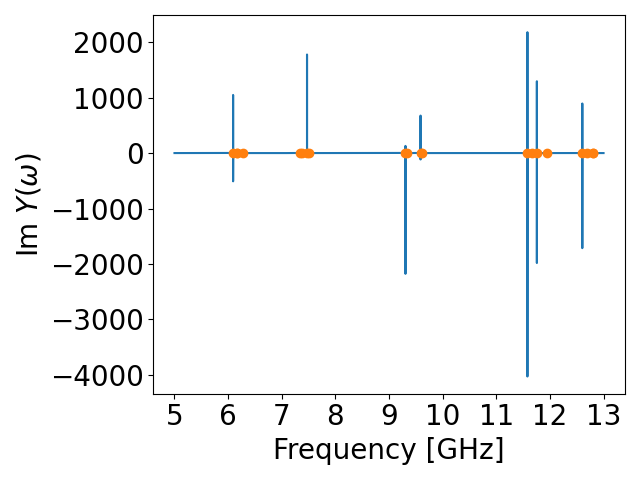

In [18]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata, ydata.imag)
ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'Im $Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
#ax.set_xlim([6.08, 6.081])
# fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')

## Iterate over all coupler offset values, fix LJ=10 nH

In [34]:
NLJ = 35
wps = []
pcs = []
pls = []
gDs = []
Cps = []
Lps = []
Qps = []
chis = []
Nmodes = 6

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = False
print_results = True

# LJs = np.logspace(np.log10(0.1e-9), np.log10(1000e-9), NLJ)
LJs = np.logspace(np.log10(1e-9), np.log10(100e-9), NLJ)
# LJs = np.logspace(np.log10(0.00001e-9), np.log10(0.0001e-9), NLJ)
# LJs = np.logspace(np.log10(0.1), np.log10(100), NLJ)
LJ0 = 10e-9
#for idx, x in enumerate(xdata):
for LJ in LJs:
    wpp, Lp, Cp, Qp, _, _, _, pl, pc, gD, chip \
    = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
    if print_results:
        print(f'wpp: {wpp}')
        print(f'Lp: {Lp}')
        print(f'Cp: {Cp}')
        print(f'pl: {pl}')
        print(f'pc: {pc}')
        print(f'chip: {chip}')
    # wps.append(np.sort(wpp[0:Nmodes]))
    wps.append(wpp[0:Nmodes])
    pls.append(pl[0:Nmodes])
    pcs.append(pc[0:Nmodes])
    gDs.append(gD[0:Nmodes])
    Lps.append(Lp[0:Nmodes])
    Cps.append(Cp[0:Nmodes])
    Qps.append(Qp[0:Nmodes])
    chis.append(chip[0:Nmodes, 0:Nmodes])
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
pls  = np.asarray(pls).T
pcs  = np.asarray(pls).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
Qps = np.asarray(Qps).T
chis = np.asarray(chis).T

wpp: [3.79369681e+10 3.82841820e+10 3.87623072e+10 3.87635538e+10
 4.58210688e+10 4.60929448e+10 4.68598754e+10 4.69434769e+10
 5.71148381e+10 5.84754442e+10 5.94544676e+10 6.02432612e+10
 6.15455292e+10 7.27631462e+10 7.34104702e+10 7.38703742e+10
 7.59481633e+10 7.59686892e+10 7.61123705e+10 7.61328964e+10
 7.62971037e+10 7.91936295e+10 8.02602103e+10 8.04323520e+10
 8.06100002e+10]
Lp: [2.34963073e-11 1.21984003e-16 8.38020906e-11 1.79719081e-14
 2.10397472e-11 6.19532898e-15 5.52313058e-11 4.57263540e-16
 1.44261107e-10 1.79151383e-17 3.50042524e-10 1.87513471e-16
 1.12102642e-10 5.30470382e-18 3.21511068e-11 1.01799278e-17
 3.11216183e-13 3.16089459e-11 5.86654337e-12 1.59316501e-11
 6.89859381e-11 1.05775725e-17 1.36051987e-10 5.28422296e-16
 9.40002057e-11]
Cp: [2.95716220e-11 5.59317461e-06 7.94192732e-12 3.70304201e-08
 2.26375307e-11 7.59743018e-08 8.24541331e-12 9.92391233e-07
 2.12497019e-12 1.63242326e-05 8.08183919e-13 1.46943568e-06
 2.35500120e-12 3.56054042e-05 5.77149

  -2.17125163e+03 -7.78663449e+07 -1.54659990e+04 -1.91991734e+06]]
wpp: [3.82841820e+10 3.87587283e+10 3.87635538e+10 3.93925559e+10
 4.60929448e+10 4.63819713e+10 4.69434769e+10 4.71635995e+10
 5.84754442e+10 5.86183591e+10 6.02432612e+10 6.03667333e+10
 7.27631462e+10 7.33167301e+10 7.38703742e+10 7.50852105e+10
 7.91936295e+10 7.97610464e+10 8.04323520e+10 8.04569418e+10]
Lp: [1.21984003e-16 1.22457953e-09 1.79719080e-14 4.24475317e-10
 6.19532858e-15 5.26094435e-10 4.57263540e-16 4.22895488e-11
 1.79151383e-17 8.16345091e-09 1.87513471e-16 7.11196517e-09
 5.30470382e-18 6.38249785e-11 1.01799278e-17 3.45032568e-08
 1.05775725e-17 1.34873556e-08 5.28422296e-16 8.14062434e-12]
Cp: [5.59317461e-06 5.43593139e-13 3.70304203e-08 1.51816592e-12
 7.59743066e-08 8.83563743e-13 9.92391234e-07 1.06304846e-11
 1.63242326e-05 3.56499480e-14 1.46943568e-06 3.85846912e-14
 3.56054042e-05 2.91476233e-12 1.80017492e-05 5.14080468e-15
 1.50741729e-05 1.16544425e-14 2.92521189e-07 1.89764619e-11]
p

In [35]:
wp0,_ , _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=None)

In [36]:
wp0/(2*np.pi*fscale)

array([ 6.0931168,  6.1686272,  6.1694112,  6.2694368,  7.33592  ,
        7.3818688,  7.4712864,  7.5060352,  9.306656 ,  9.3293312,
        9.5880128,  9.6076096, 11.5806144, 11.66872  , 11.7568352,
       11.95032  , 12.6040576, 12.6945024, 12.8012064, 12.80512  ])

In [37]:
wp0.shape

(20,)

In [38]:
wps.shape

(6, 35)

## Plot the modes of coupled structure

<IPython.core.display.Javascript object>


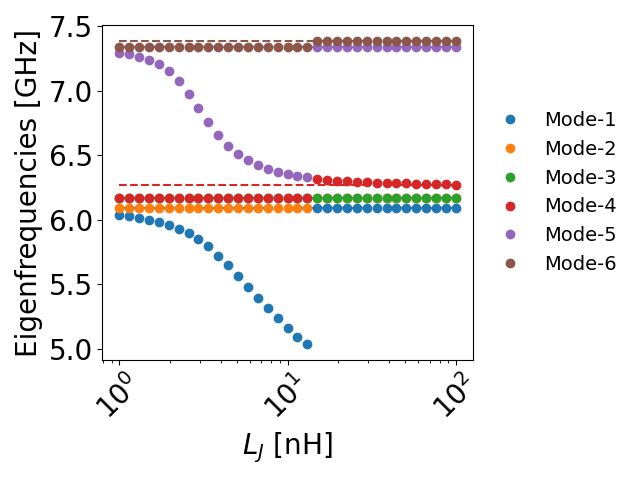

In [39]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [40]:
dw

NameError: name 'dw' is not defined

In [41]:
wps[0]

array([3.79369681e+10, 3.78683256e+10, 3.77996830e+10, 3.76967192e+10,
       3.75937554e+10, 3.74564703e+10, 3.72505427e+10, 3.70446150e+10,
       3.67357236e+10, 3.63925109e+10, 3.59463344e+10, 3.54658366e+10,
       3.49510175e+10, 3.44361984e+10, 3.38870581e+10, 3.33722390e+10,
       3.28917412e+10, 3.24112434e+10, 3.19993882e+10, 3.16218542e+10,
       3.82841820e+10, 3.82841820e+10, 3.82841820e+10, 3.82841820e+10,
       3.82841820e+10, 3.82841820e+10, 3.82841820e+10, 3.82841820e+10,
       3.82841820e+10, 3.82841820e+10, 3.82841820e+10, 3.82841820e+10,
       3.82841820e+10, 3.82841820e+10, 3.82841820e+10])

## Plot the splittings of the lowest modes vs LJ

<IPython.core.display.Javascript object>


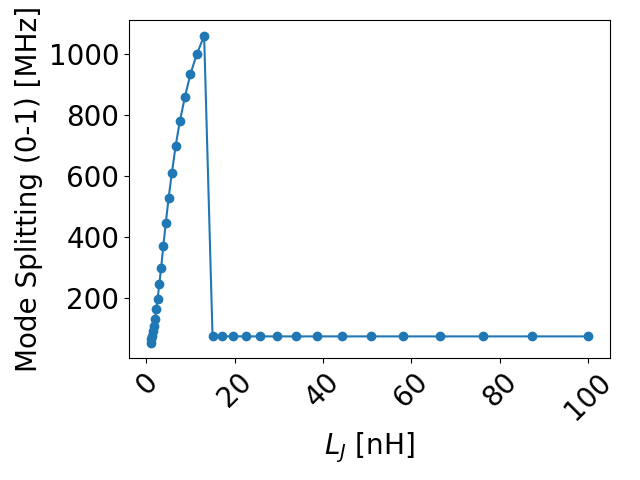

In [51]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ax.plot(LJs/1e-9, (wps[1]-wps[0])/(2*np.pi*fscale2),
           'o-',
            color=cycle[0%clen])
# ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting (0-1) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
#ax.set_ylim([0, 100])
#ax.set_xlim([1, 2.2])
#ax.set_xscale('log')
fig.savefig(f'../figs/modes_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            format='pdf')

## Mode losses

<IPython.core.display.Javascript object>


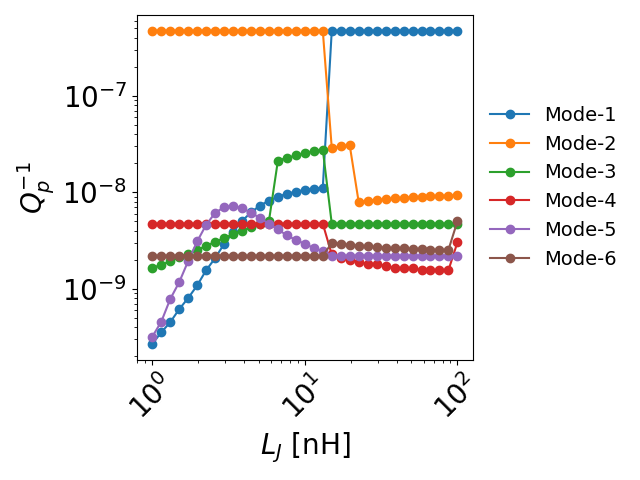

In [52]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps):
    ax.plot(LJs/1e-9, 1./Q,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Q_p^{-1}$', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_losses_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

## Black box results

### $\alpha_p$ and $\chi_{pq}$

In [53]:
chis.shape

(6, 6, 35)

<IPython.core.display.Javascript object>


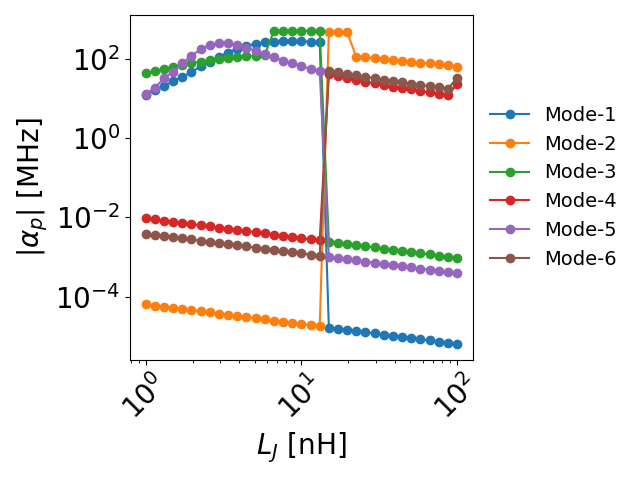

In [54]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx in range(Nmodes):
    ax.plot(LJs/1e-9, 0.5 * np.abs(chis[idx, idx, :]) / fscale2,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\alpha_p|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_alpha_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [55]:
# Chi, lower triangle
chiT = np.array([np.triu(chis[:,:,i]) for i in range(len(LJs))]).T

In [56]:
chiT[0:NM,0:NM,0]

array([[-2.44181071e+07,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-5.58910158e+04, -1.27929885e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.66136502e+07, -1.06694768e+05, -8.89844729e+07,
         0.00000000e+00,  0.00000000e+00],
       [-6.82636907e+05, -1.56249909e+03, -1.30313942e+06,
        -1.90839177e+04,  0.00000000e+00],
       [-2.53941537e+07, -5.81251053e+04, -4.84769026e+07,
        -7.09923438e+05, -2.64092151e+07]])

<IPython.core.display.Javascript object>


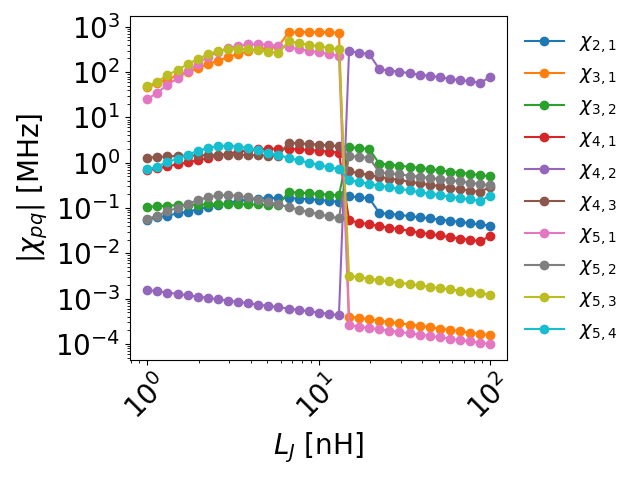

In [57]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
NM = 5
idx = 0
for i in range(NM):
    for j in range(NM):
        if (i != j) and np.any(chiT[i, j, :] != 0.):
            ax.plot(LJs/1e-9, np.abs(chiT[i, j, :]) / fscale2,
                'o-', label=r'$\chi_{%d,%d}$' % (i + 1, j + 1),
                color=cycle[idx%clen])
            idx += 1
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$|\chi_{pq}|$ [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_chi_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')